In [1]:
from datasets import load_dataset

In [48]:
dataset = load_dataset("Rtian/DebugBench")
# Print out some information about the dataset
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['release_time', 'examples', 'bug_explanation', 'category', 'slug', 'solution', 'buggy_code', 'solution_explanation', 'question', 'level', 'language', 'subtype', 'constraints'],
        num_rows: 4253
    })
})


In [49]:
import difflib

def remove_blank_lines(text):
    return "\n".join([s for s in text.splitlines() if s])

def custom_diff(file1_contents, file2_contents):
    diff = difflib.ndiff(file1_contents.splitlines(), file2_contents.splitlines())
    
    old_lines = []

    current_line_number = 1
    for line in diff:        
        if line.startswith('  '):
            current_line_number += 1
            continue
        elif line.startswith('- '):  # Lines in file1 but not in file2
            old_lines.append([current_line_number, line[2:]])
            current_line_number += 1        
    return old_lines

solution = """def sum(a, b):
                sum = 0
                return sumum
            """

buggy_code = """def sum(a, b):
                sum = 3
                zzzz
                return sum
            """

#old = custom_diff(buggy_code, solution)
#print(old)

In [50]:
import subprocess

def format_cpp_code(code):
    try:
        process = subprocess.Popen(['clang-format', '-style=file:./clang-format.txt'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        
        if process.returncode != 0:
            print("Error formatting code: ", errors.decode())
            return None
        
        return formatted_code.decode()
    except Exception as e:
        print(f"An exception occurred: {e}")
        return None


In [51]:
def process_result_json(input_json, ignored_tokens=[]):
    current_max_perplexity = 0
    result_max = []
    result_all = []
    current_line = []
    for perplexity, token in input_json:
        perplexity = float(perplexity)
        if token in ignored_tokens:
            perplexity = 0.0

        num_lines = len(token.split("\n")) -1
        
        if num_lines == 0:
            # No new line
            current_line.append((perplexity, token))
            current_max_perplexity = max(current_max_perplexity, perplexity)
        else:
            # New line (or multiple)
            current_max_perplexity = max(current_max_perplexity, perplexity)
            result_max.append(current_max_perplexity)
            current_line.append((perplexity, token))
            result_all.append(current_line)
            for _ in range(num_lines - 1):
                # multiple new lines
                result_all.append([(perplexity, token)])
                result_max.append(perplexity)
            if not token.endswith("\n"):
                current_line = [(perplexity, token)]
                current_max_perplexity = perplexity
            else:
                current_line = []
                current_max_perplexity = 0
    return result_max, result_all

In [72]:
import requests as req
counter = 0
counter_multi_diff = 0
buggy_code_list = []
solutions = []
diffs = []
perplexity_per_line = []
perplexity_per_token = []
ignored_tokens = ["▁"*i for i in range(1, 30)] + ["\n"*i for i in range(1, 5)] + ["▁{", "1", "int", ","]

for entry in dataset['test']:
    if entry['language'] == 'cpp' and entry['category'] == 'logic error':
        counter += 1
        buggy_code = format_cpp_code(remove_blank_lines(entry['buggy_code']))
        data = {"prompt": buggy_code}
        resp = req.post("http://delos.eaalab.hpi.uni-potsdam.de:8010/highlight-code/", json=data)
        resp_json = resp.json()["generated_text"]
        result_max, result_all = process_result_json(resp_json, ignored_tokens)
        perplexity_per_line.append(result_max)
        perplexity_per_token.append(result_all)
        solution = format_cpp_code(remove_blank_lines(entry['solution']))
        diff = custom_diff(buggy_code, solution)
        solutions.append(solution)
        diffs.append(diff)
        buggy_code_list.append(buggy_code)
        if len(diff) != 1:
        #    print("Buggy Code:")
        #    print(buggy_code)
        #    print("\nSolution:")
        #    print(solution)
        #    print(diff)
        #    print("\n" + "="*40 + "\n")
            counter_multi_diff +=1
print(counter_multi_diff)
print(counter)


45
200


In [73]:
avg_counter = 0
avg_sum = 0
for i in range(len(solutions)):
    diff = diffs[i]
    for item in diff:
        line_number = item[0]
        #if line_number >= len(perplexity_per_line[i]):
        #    print("Alarm")
        #    print(line_number, len(perplexity_per_line[i]))
        #    continue
        #print(perplexity_per_line[i])
        #print(item[1])
        actual_perplexity = perplexity_per_line[i][line_number-1]
        if actual_perplexity != 0:
            counter = 0
            for perplexity in perplexity_per_line[i]:
                if perplexity > actual_perplexity:
                    counter += 1
            percentage = counter / len(perplexity_per_line[i])
            if percentage < 0.2:
                avg_counter += 1
                avg_sum += actual_perplexity

print(avg_sum / avg_counter)
                    

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0.8698584929509409


In [74]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [75]:
total_num_lines = 0
labels = []
predictions = []
predictions_all = []
num_positives = 0
for i in range(200):
    current_num_lines = len(perplexity_per_line[i])
    total_num_lines += current_num_lines
    current_labels = [False for _ in range(current_num_lines)]
    for item in diffs[i]:
        line = item[0]
        current_labels[line-1] = True
        num_positives += 1
    predictions.extend(perplexity_per_line[i])
    predictions_all.extend(perplexity_per_token[i])
    labels.extend(current_labels)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.7761845591955593
Area 0.8271457584170222
2079


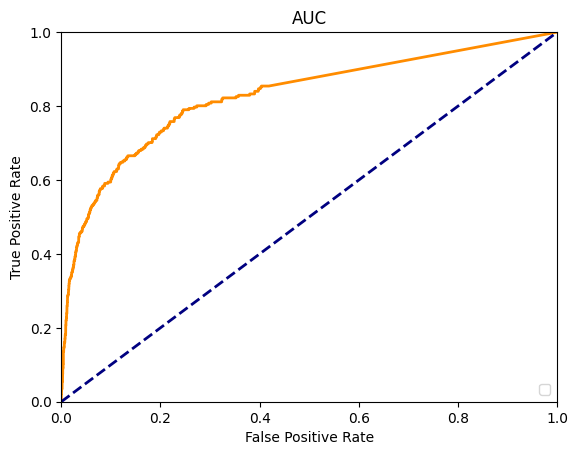

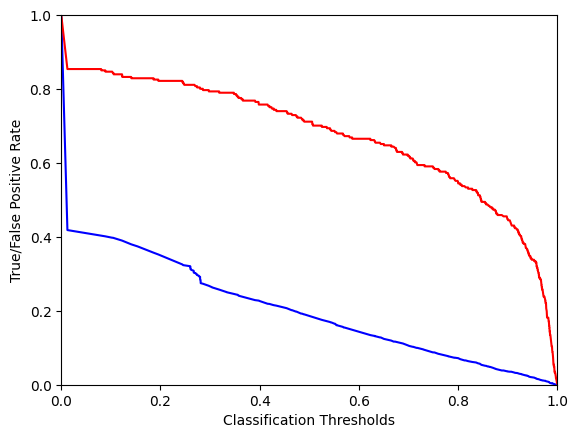

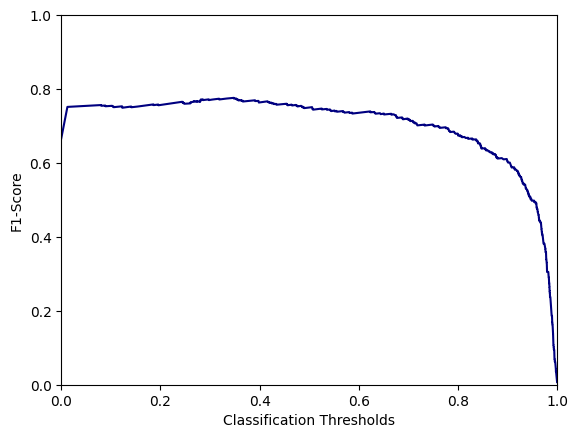

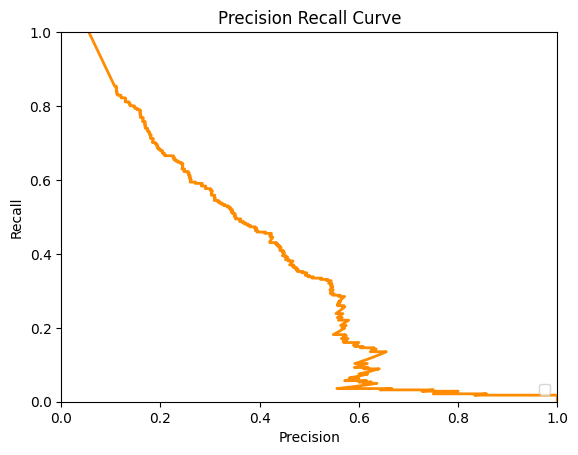

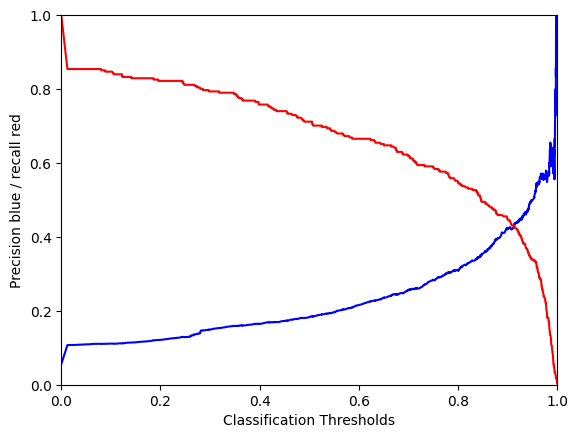

In [76]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, predictions)
precision, recall, thresholds2 = precision_recall_curve(labels, predictions)
fn = [(num_positives) - tp * num_positives for tp in tpr]
f1 = [(2*tpr[i]*num_positives)/(2*tpr[i]*num_positives + fpr[i]*num_positives + fn[i]) for i in range(len(fpr))]
print(max(f1))

roc_auc = auc(fpr, tpr)
print("Area", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.legend(loc='lower right')

plt.figure()
plt.plot(thresholds, fpr, color='blue')
plt.plot(thresholds, tpr, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('True/False Positive Rate')

plt.figure()
plt.plot(thresholds, f1, color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('F1-Score')

plt.figure()
plt.plot(precision, recall, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.legend(loc='lower right')

length = min(len(precision), len(recall))
plt.figure()
plt.plot(thresholds2, precision[:length-1], color='blue')
plt.plot(thresholds2, recall[:length-1], color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Classification Thresholds')
plt.ylabel('Precision blue / recall red')

plt.show()

403
0.9949948994617444
};
Substring
7
2
0
0.9914776661025826
0
▁vector
▁return
▁_
▁,
};
Substring
Cost
After
;
7
2
0.9851414352306165
7
2
0
▁x
▁vector
▁return
▁p
▁mn
▁ind
▁_
▁,
};
days
Substring
Cost
Assignment
After
;
)
(
0.9834472169413857
▁return
pair
7
2
0
▁x
▁vector
▁p
▁mn
▁max
▁ind
▁_
▁Find
▁,
▁(
▁&&
};
sum
left
days
0.9779351204342674
▁return
pair
2
▁(
7
0
▁x
▁vector
▁p
▁mn
▁max
▁ind
▁and
▁_
▁Find
▁<=
▁,
▁+
▁&&
};
0.969784594113662
▁return
pair
2
▁+
▁(
;
7
0
▁x
▁vector
▁tweets
▁p
▁mn
▁max
▁ind
▁i
▁and
▁accumulate
▁_
▁Find
0.9637891508173198
▁return
▁+
2
pair
▁<=
▁(
]
;
7
0
)
▁||
▁x
▁vector
▁tweets
▁p
▁mn
▁max
▁ind
▁i
0.9600547309964895
2
▁return
▁+
pair
0
▁<=
▁(
]
Primes
;
7
)
▁||
▁x
▁vector
▁value
▁tweets
▁start
▁p
▁mn
0.9532490037381649
2
▁return
▁+
▁(
pair
]
0
▁ans
▁<=
▁,
▁((
if
begin
Primes
;
7
)
▁||
▁x
▁vector
0.9422609278117307
2
pair
▁return
▁+
▁(
]
0
(
▁ans
▁<=
▁,
▁((
if
begin
Primes
;
7
)
▁||
▁x
0.9352374915033579
2
▁return
▁+
pair
▁(
vector
]
0
(
▁ans
▁and
▁<=
▁,
▁*
▁(

/tmp/ipykernel_25146/1169043030.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


0.5863434672355652
if
vector
▁(
//
▁+
;
2
▁-
▁&&
(),
▁vector
pair
▁return
0
)
▁and
▁<=
for
string
]
0.5545997619628906
if
vector
//
▁(
▁+
▁-
;
2
▁&&
)
(),
▁vector
▁return
pair
for
0
▁and
▁<=
string
bool
0.5251979796121304
if
▁(
vector
//
;
▁+
▁-
2
▁&&
)
for
▁vector
▁return
(),
string
pair
0
▁and
▁<=
▁!=
0.48342010378837585
if
▁(
vector
//
;
▁-
▁+
2
▁&&
for
)
▁vector
▁return
0
(),
pair
string
bool
▁<=
▁!=
0.4543193392455578
if
▁(
vector
//
;
▁-
▁+
0
for
2
▁&&
string
)
()
▁vector
▁return
pair
(),
▁<=
bool
0.41595661640167236
if
▁(
vector
//
;
▁-
▁+
for
0
▁return
string
2
)
▁&&
()
▁vector
pair
(),
▁<=
bool
0.36289813299663365
if
▁(
vector
//
;
▁-
for
0
)
▁+
2
▁return
string
▁vector
▁&&
()
pair
i
▁x
▁ans
0.3480287818238139
▁(
if
vector
//
;
▁-
0
for
▁+
)
2
▁return
string
▁vector
▁&&
long
()
▁x
▁ans
▁=
0.2853957563638687
▁(
if
//
vector
;
▁-
string
0
for
)
▁+
2
long
▁return
▁=
bool
()
▁vector
▁<=
▁&&
0.279892423614001
▁(
if
vector
//
▁Solution
;
▁-
string
0
for
)
▁+
2
long
▁return
▁=
bool
(

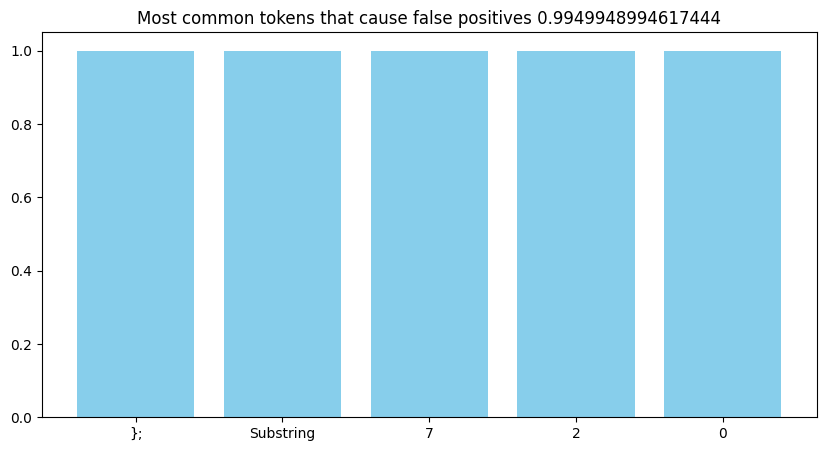

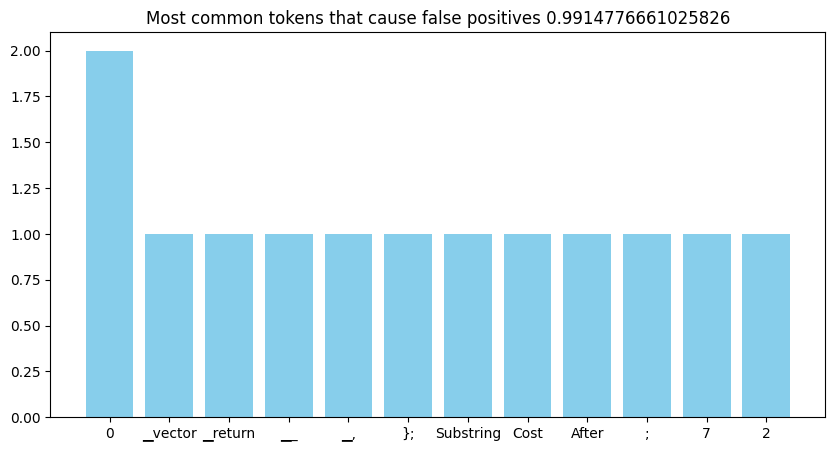

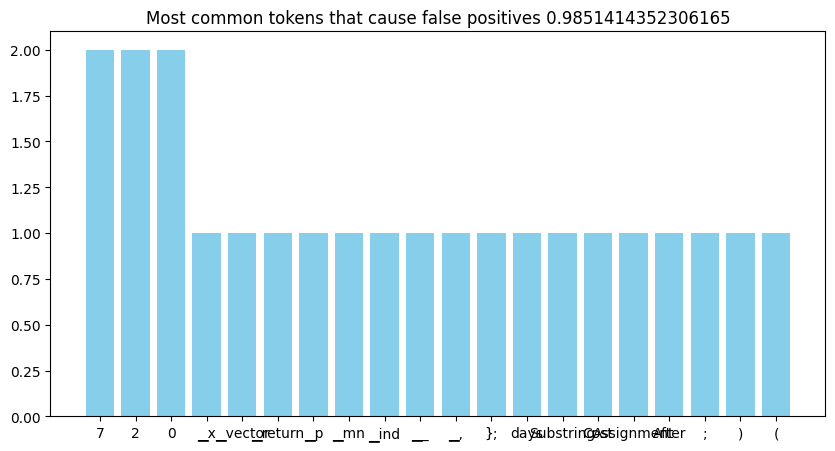

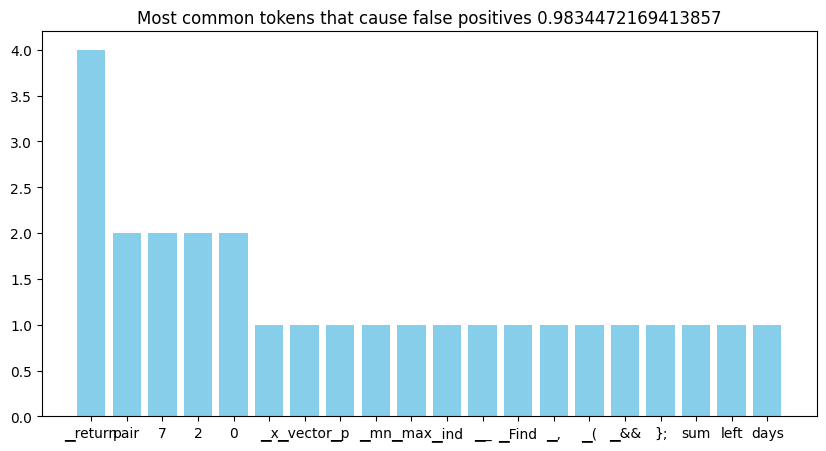

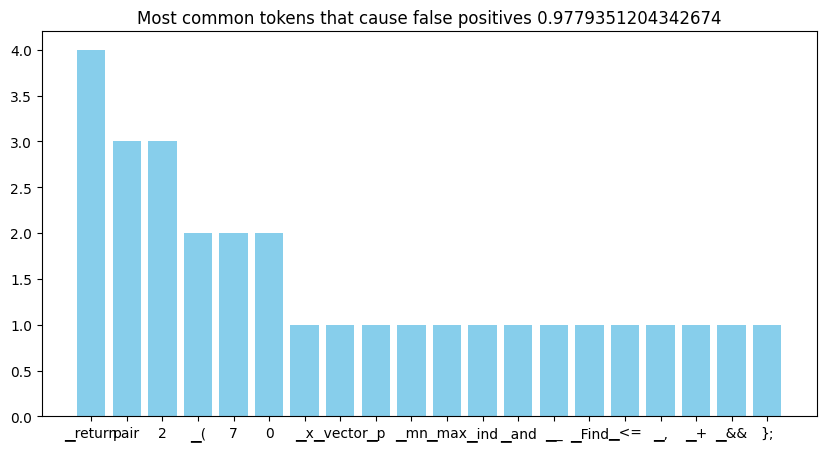

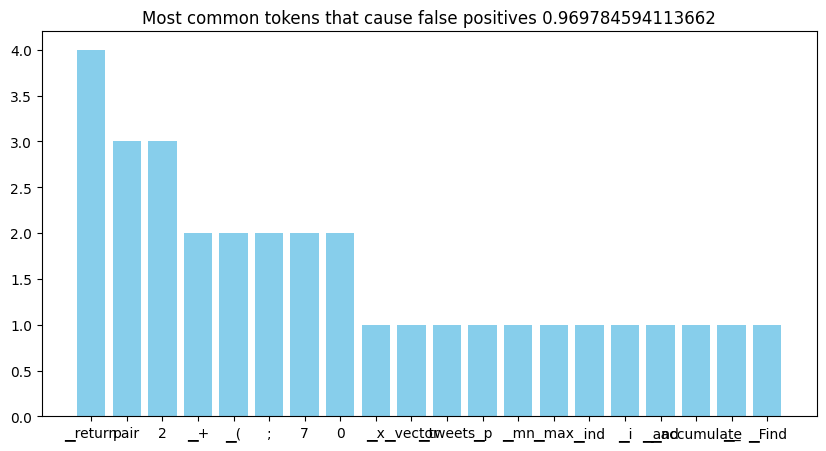

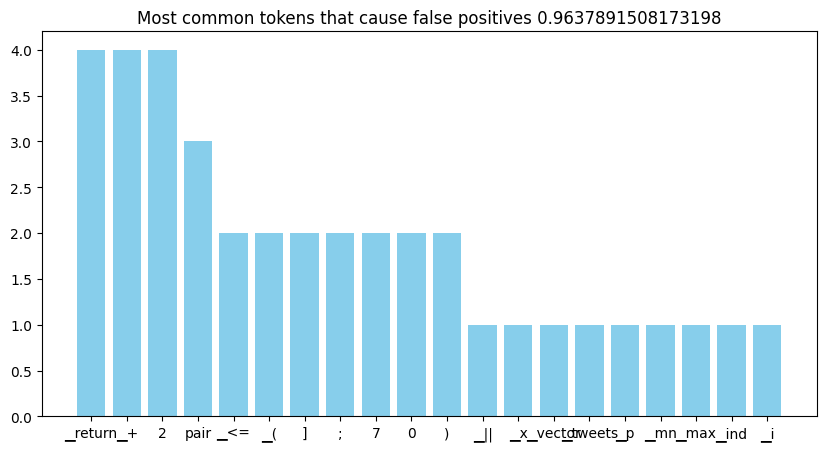

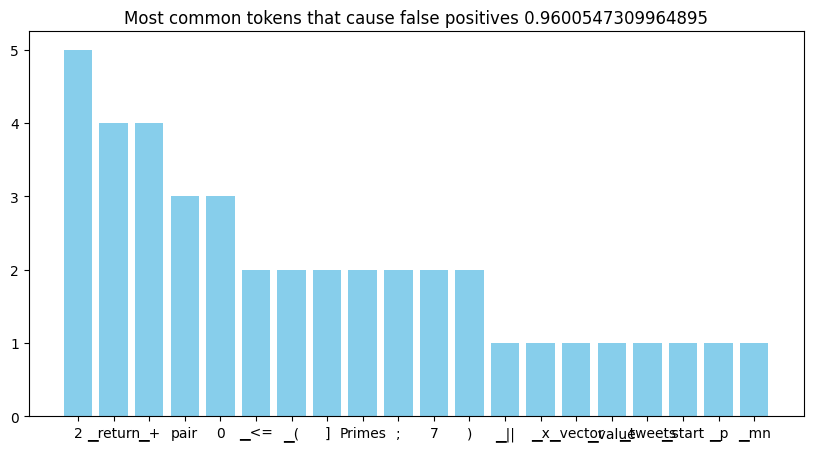

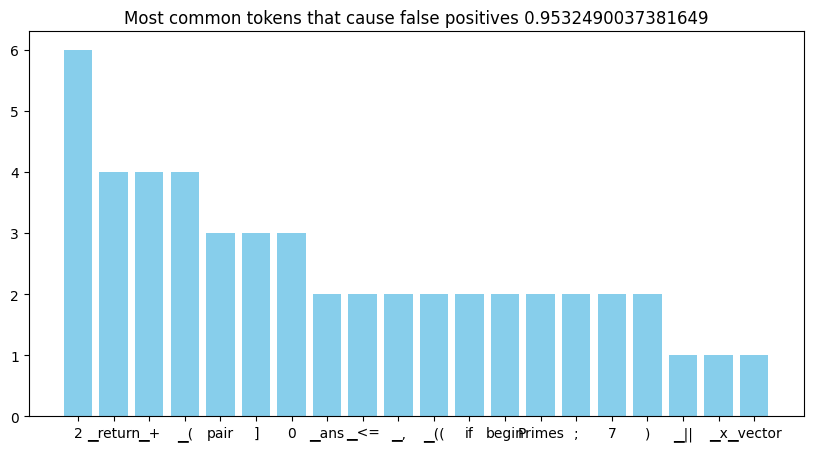

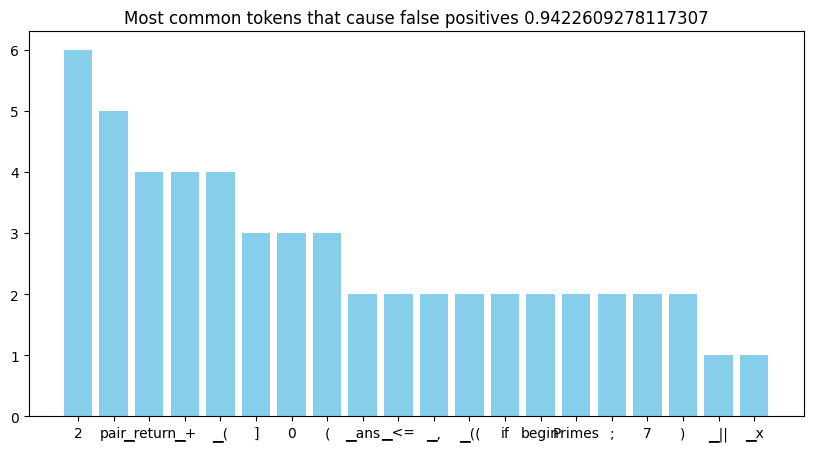

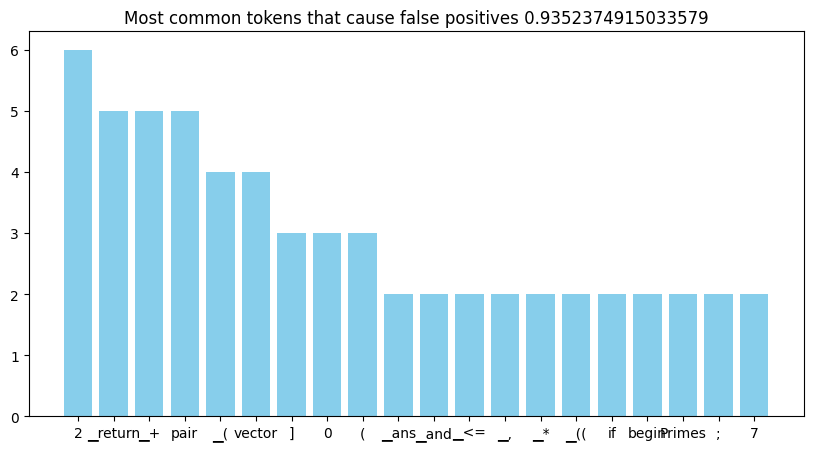

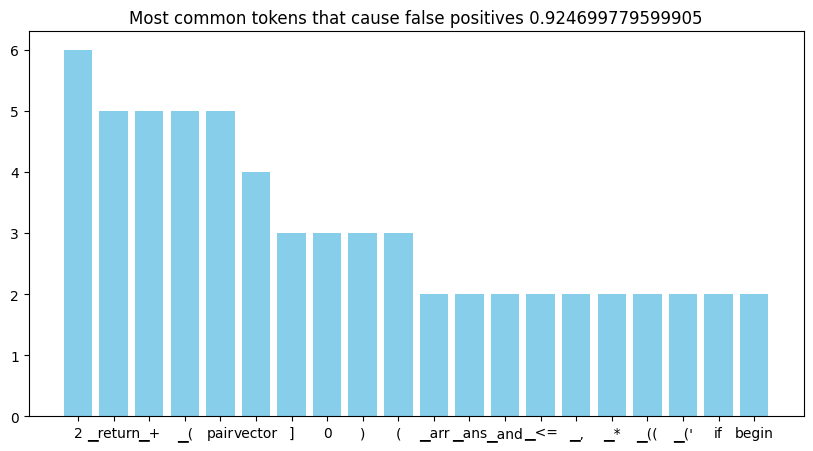

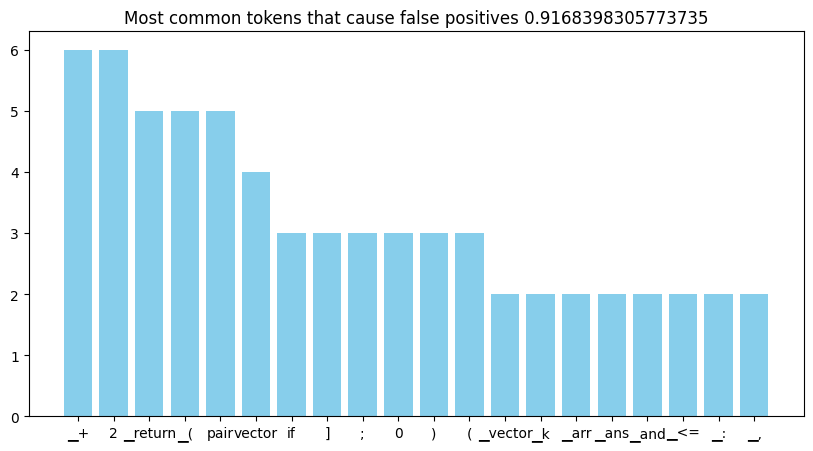

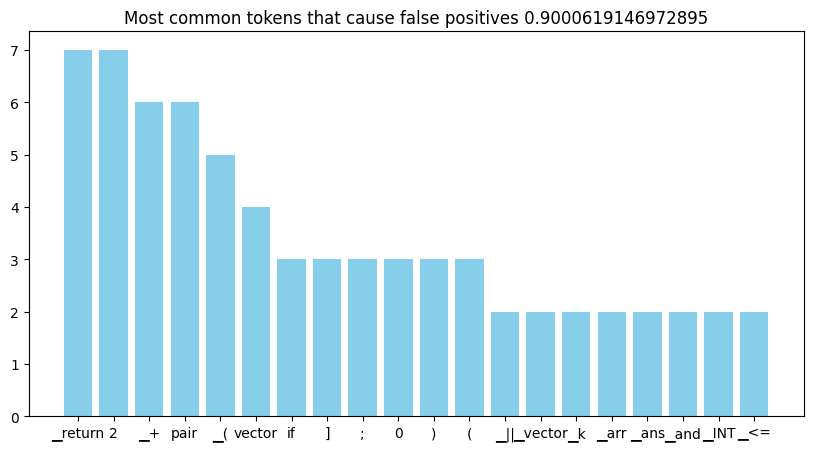

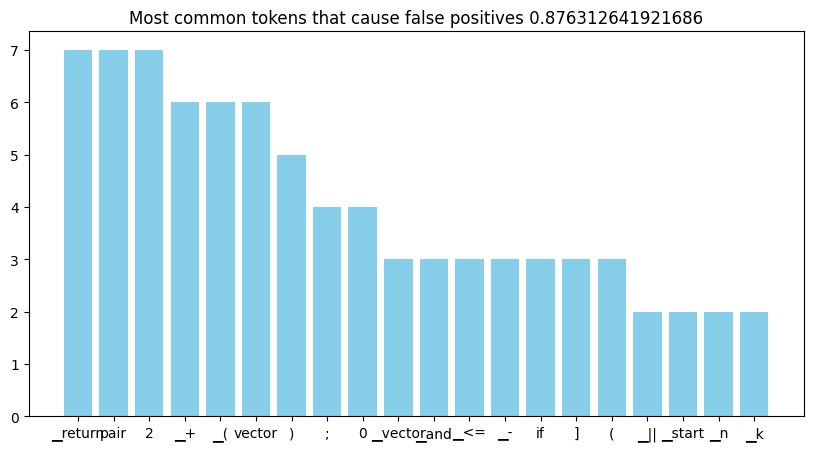

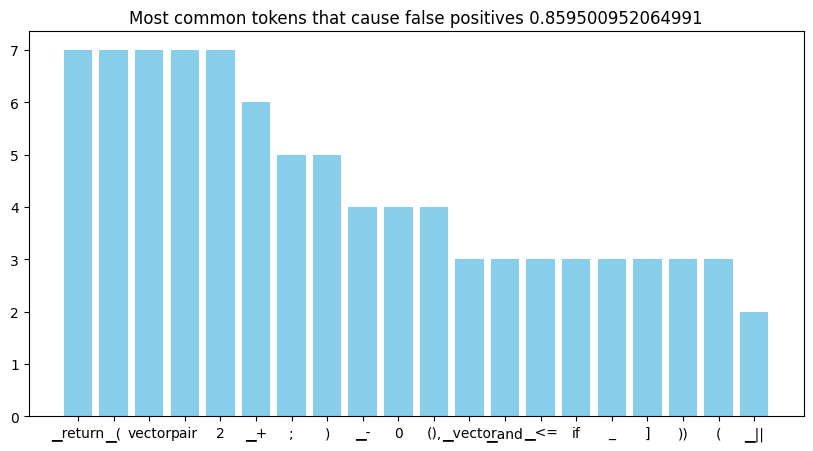

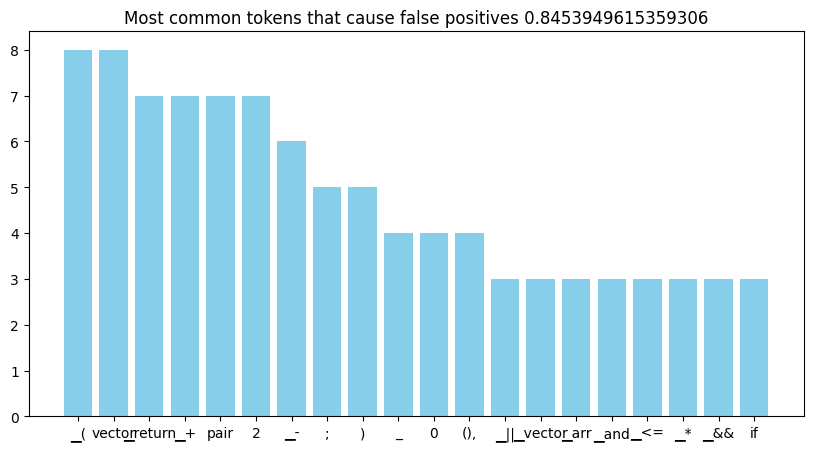

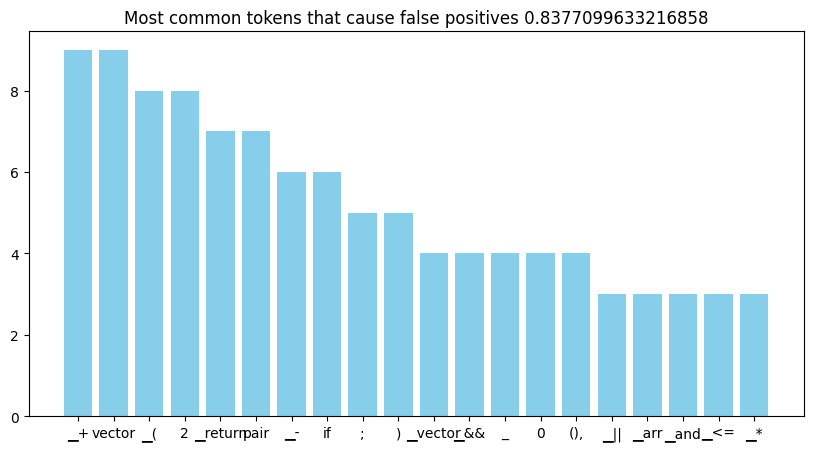

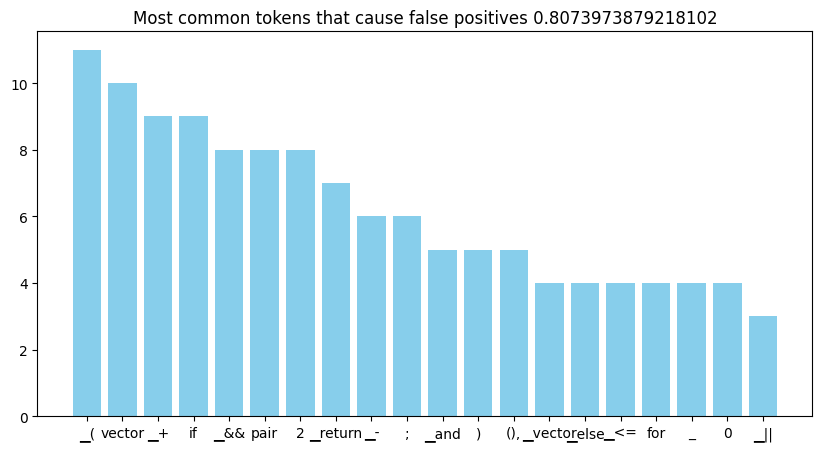

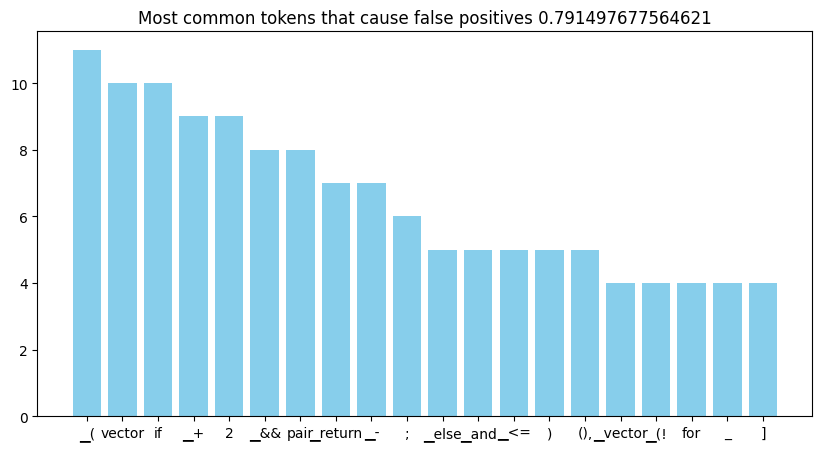

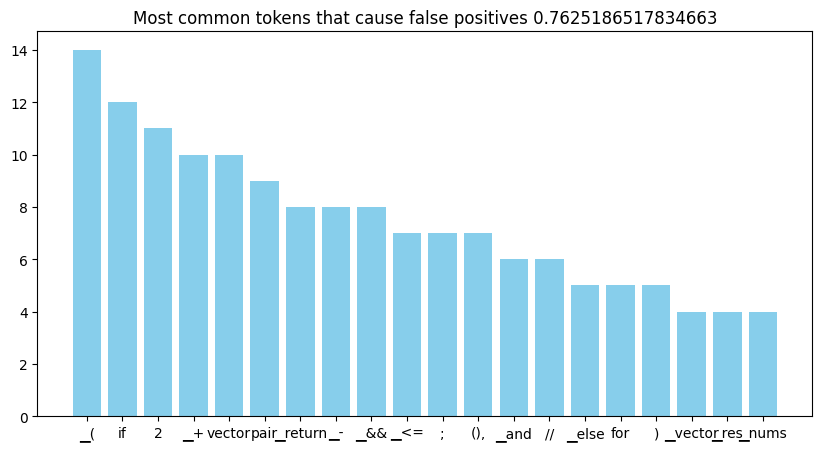

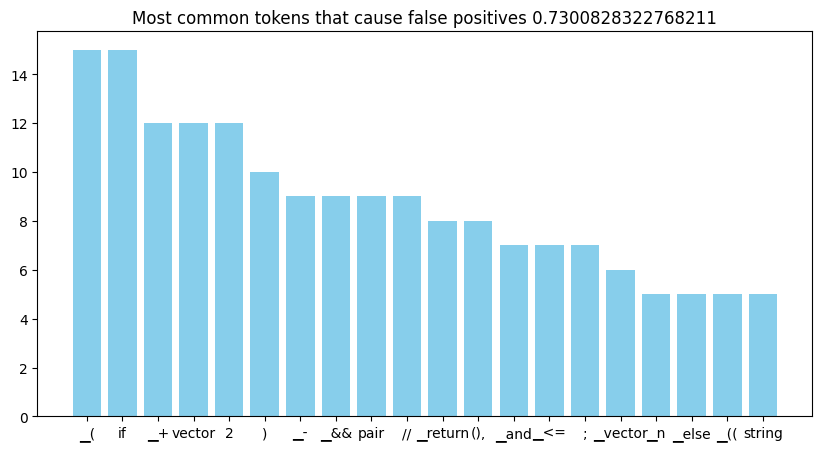

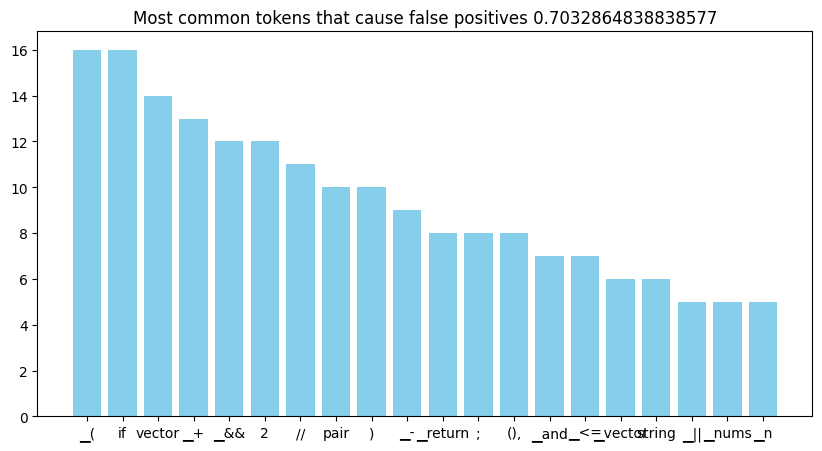

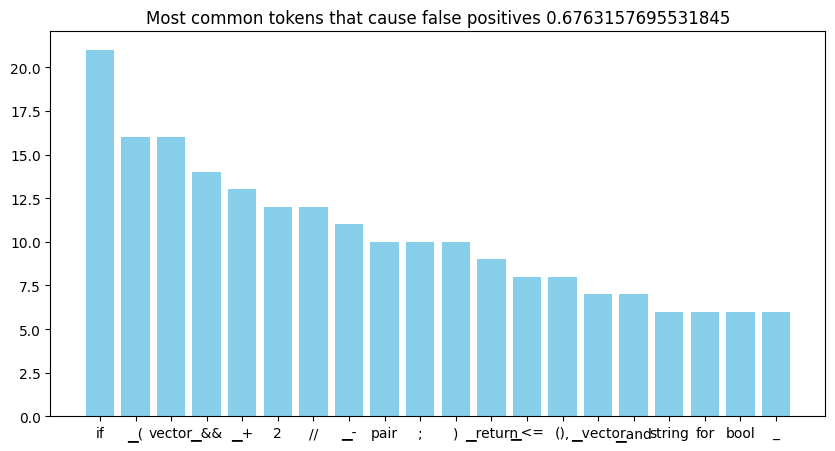

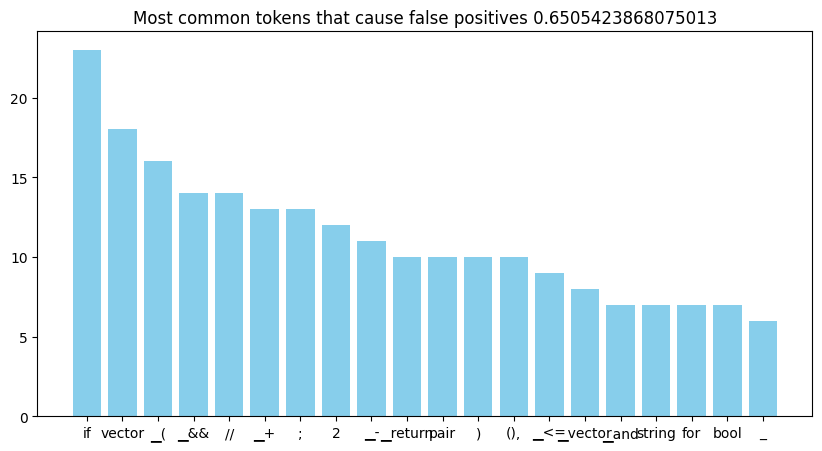

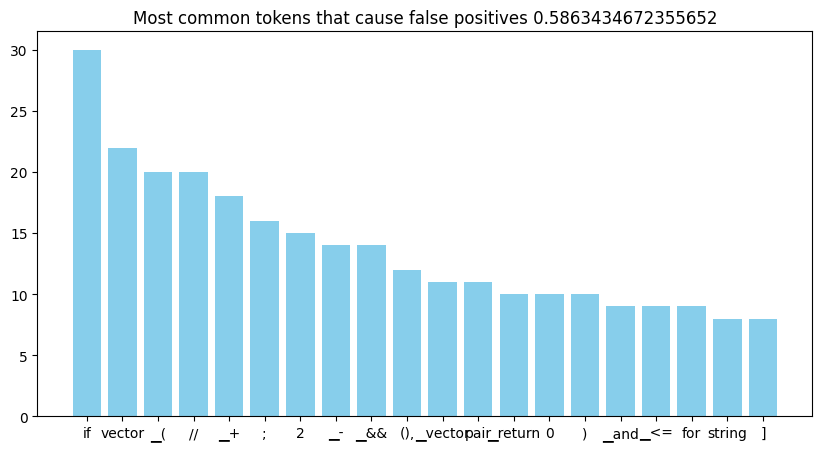

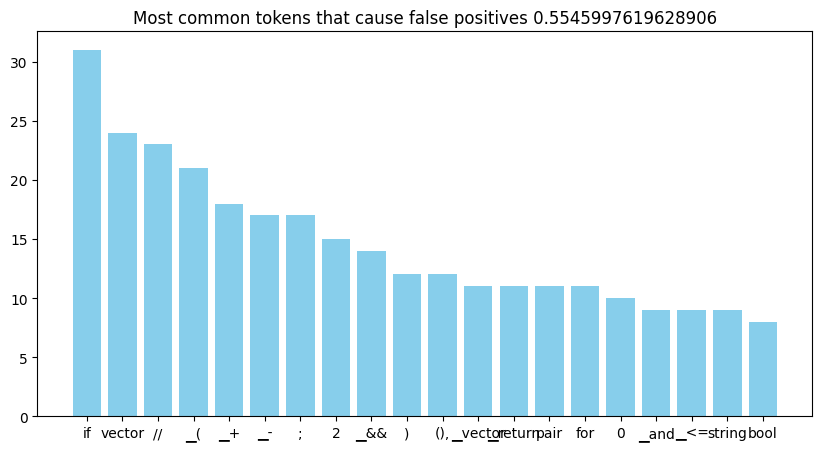

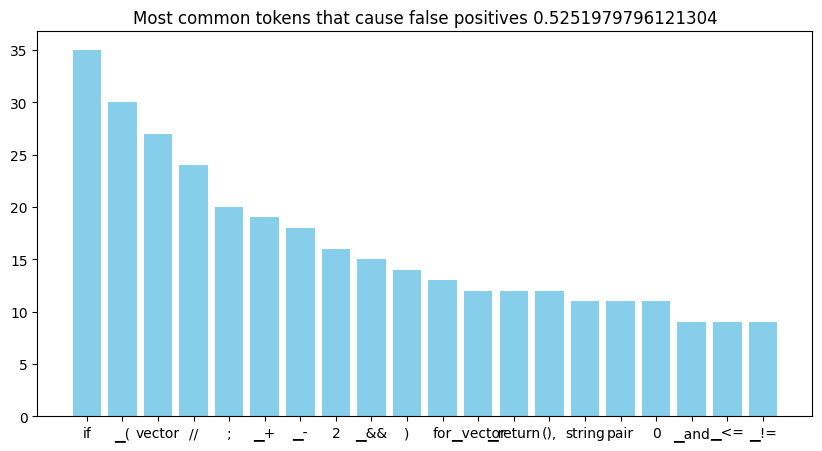

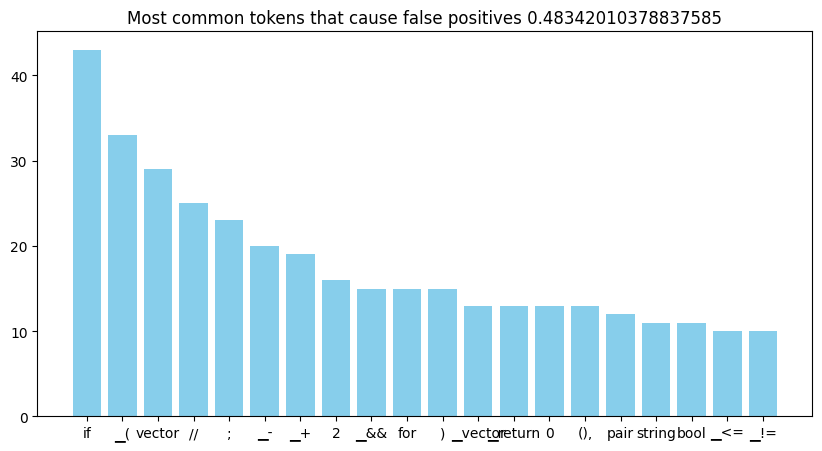

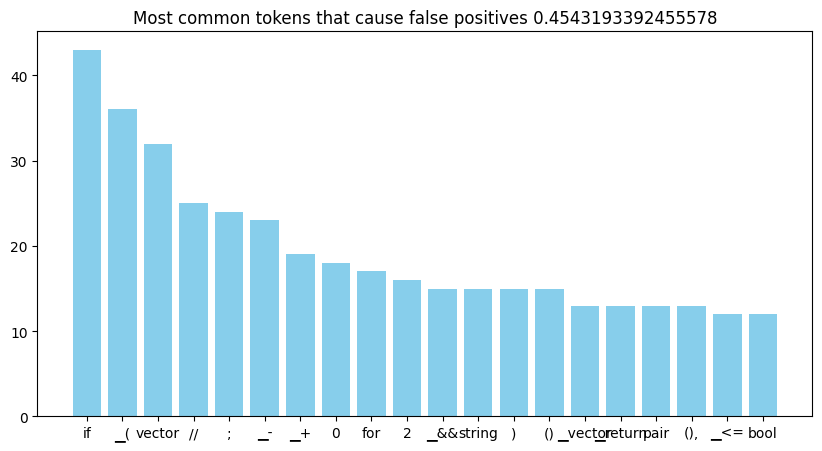

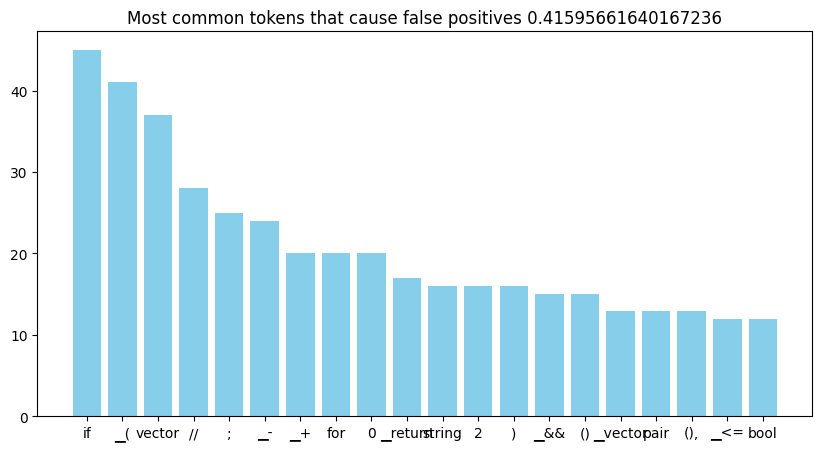

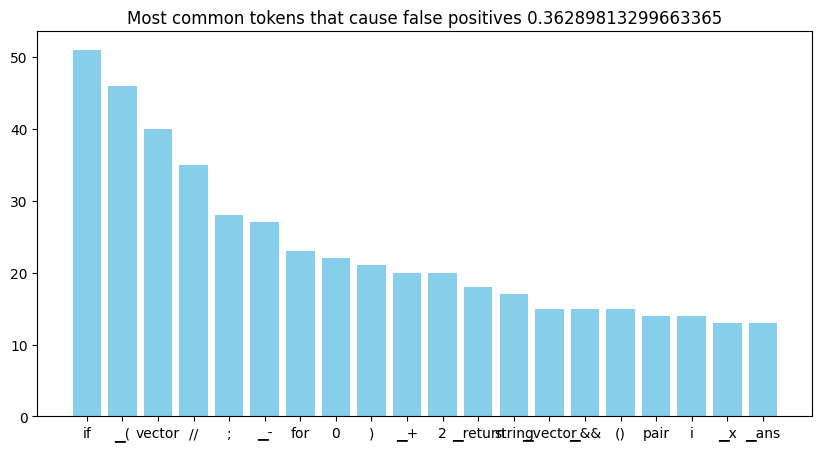

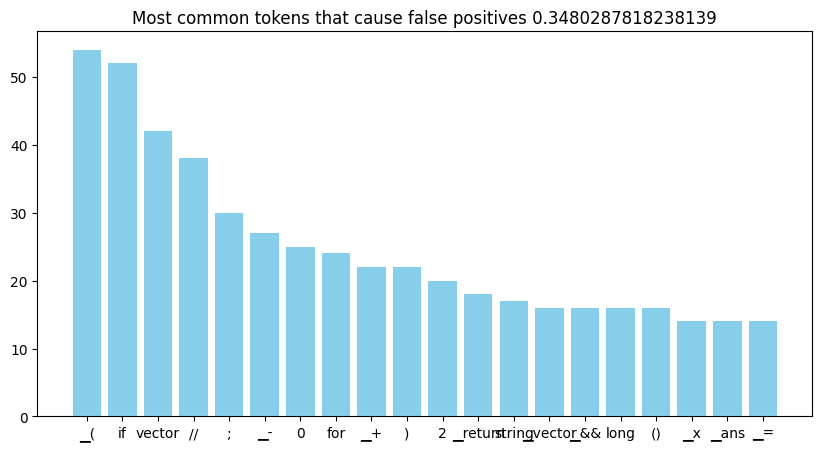

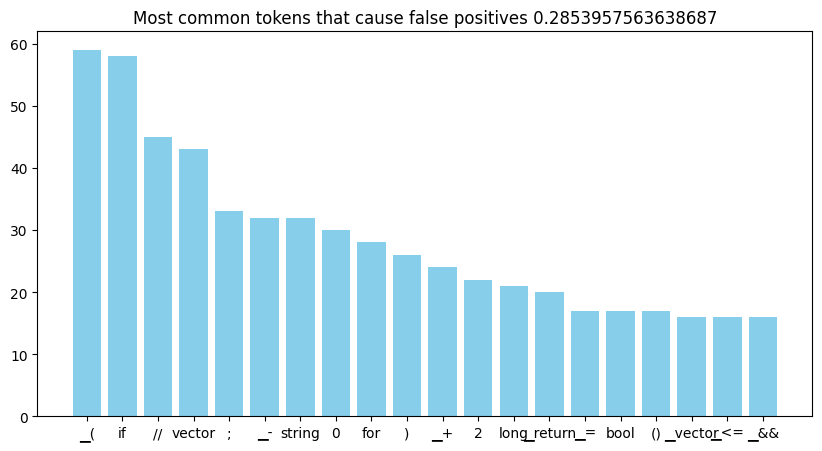

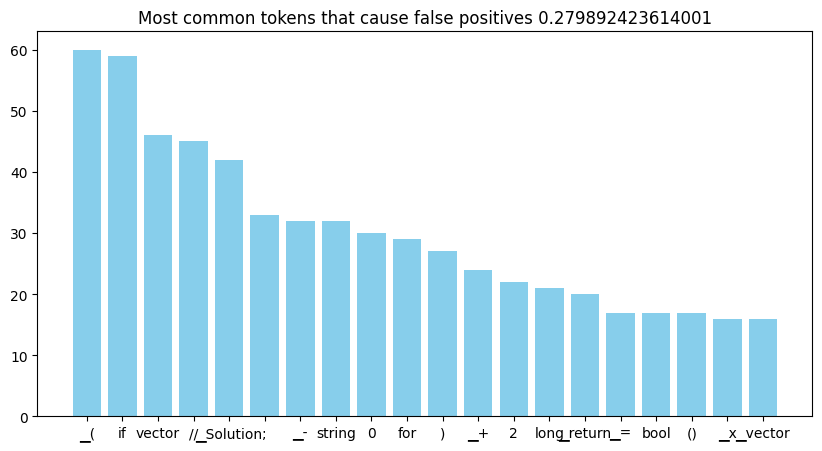

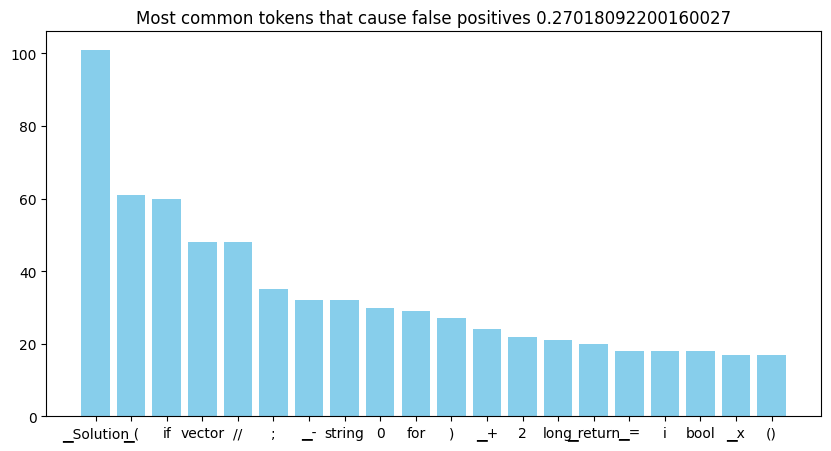

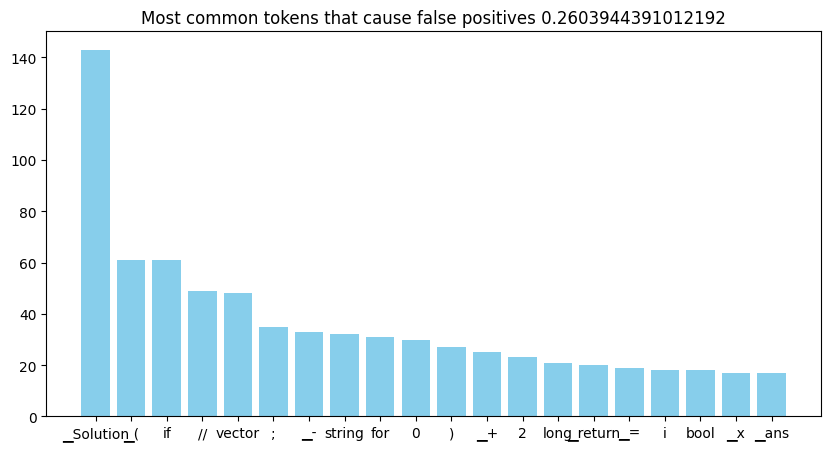

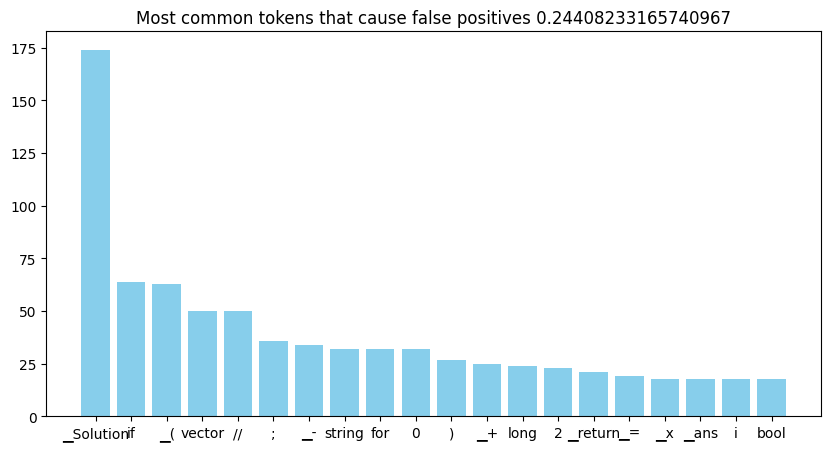

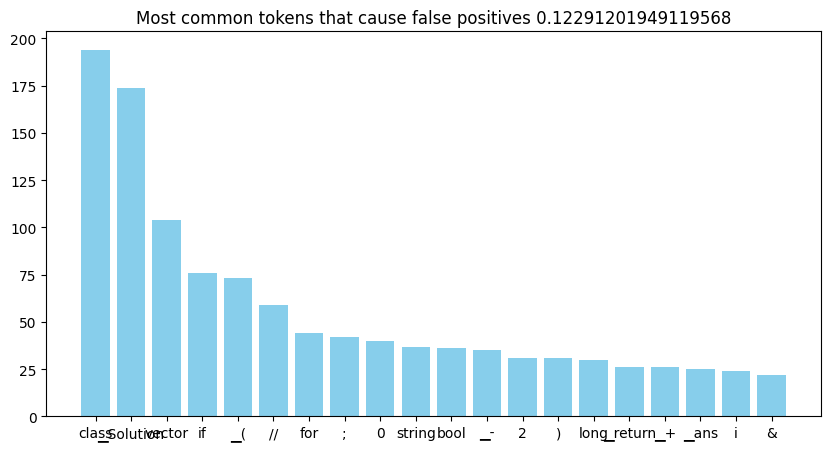

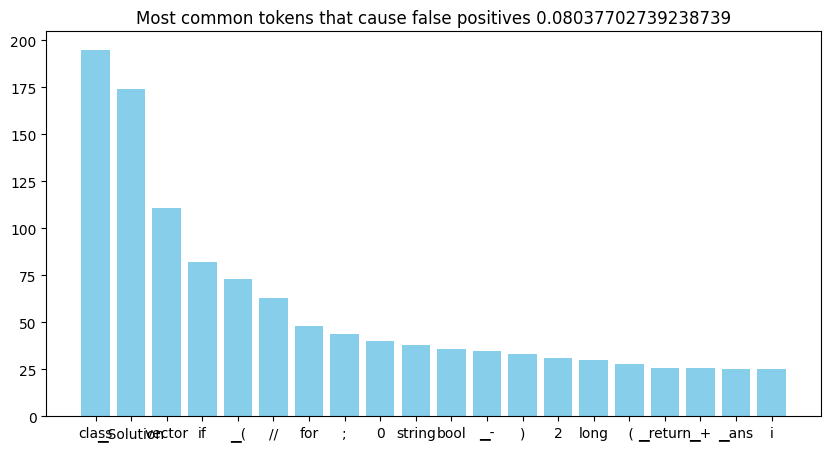

In [77]:
# Find token that cause false positives :)

def common_fpr_tokens(threshold=0.8):
    result = {}
    for line in range(total_num_lines):
        if labels[line]:
            continue
        if predictions[line] < threshold:
            continue

        for perplexity, token in predictions_all[line]:
            perplexity = float(perplexity)
            if perplexity >= threshold:
                if not (token in result):
                    result[token] = 0
                result[token] += 1

    keys = list(result.keys())
    values = list(result.values())

    # Sort the values
    values, keys = zip(*sorted(zip(values, keys), reverse=True))

    # truncate the list
    keys = keys[:20]
    values = values[:20]
    
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='skyblue')
    plt.title(f'Most common tokens that cause false positives {threshold}')
    return result
print(len(thresholds))

for i in range(10, len(thresholds), 20):
    t = thresholds[i]
    print(t)
    common_fpr_tokens(t)
